# Predicting Stock Markets with Google Trends
## Team adache
This is the notebook containing our work for the creative extension.


In [1]:
import pandas as pd
import numpy as np

import requests
import time
import datetime
import math 
import glob

import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go

from pandas import read_csv

from matplotlib import pyplot as plt

from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

# Functions

In [2]:
  # ------ DATA IMPORT ------- #

def add_year(date):
    if is_leap_year(date.year):
        delta = datetime.timedelta(days=366)
    else:
        delta = datetime.timedelta(days=365)
    return date + delta

def is_leap_year(year):
    if (year % 4) == 0:
        if (year % 100) == 0:
            if (year % 400) == 0:
                return True
            else:
                return False
        else:
            return True
    else:
        return False
    
    
    
'''
Download and save as csv the Google US Trends, interests by week, for 1 selected keyword for the period of 2004-today
'''
def dl_interest_for_keyword(keyword):
    kw_list = [keyword] # List of keywords. We're using only 1 for each method execution
    dataframes = []     # List of df for each year
    start = datetime.datetime(2004,1,1) 
    current_year = start

    # Make a request for each year
    for i in range(2020-2004+1):
        timeframe = str(current_year.year)+'-01-01 ' + str(current_year.year) + '-12-31'
        try:
            pytrends.build_payload(kw_list, cat=0, timeframe=timeframe, geo='US', gprop='')
            print('Downloading ' + str(current_year.year) + ' data...',end='')
            df = pytrends.interest_over_time()
            print('OK')
            dataframes.append(df)
            time.sleep(1) # Sleep to avoid 429, may or may not be necessary
            current_year=add_year(current_year)
        except requests.exceptions.Timeout:
            print('TIMEOUT')

    # Merge the datasets of all years
    df_merged = pd.concat(dataframes)
    df_merged.drop('isPartial',inplace=True,axis=1)

    # Save to a .csv named as the keyword 
    df_merged.to_csv(keyword +'.csv', header='interest', index_label='date')
    print('Saved as `' + keyword +'.csv'+'`')    


    
    
    # -------- PREDICTION --------#
    
def predict(X, y, window):
    """
    This function is used to make the predictions. The parameters help set up the details of the model to be used.
    window: this parameter.
    We use a window of the 'window' previous elements to train the model in order to make a prediction
    """
      
    k = window
    y_tests = []
    y_hats = []
        
    #we take at least 5 training points 
    # points in the training set up until the kth data point
     
    #for i in np.arange(5, k, 1):

     #   X_train = X[:i,:]
      #  X_test = X[i,:]

       # y_train = y[:i]
        #y_test = y[i]

        #reg = LinearRegression()
        #reg.fit(X_train, y_train)

        #X_test.reshape(1,X.shape[1])
       # y_hat = reg.predict([X_test])
       # y_tests.append(y_test)
      #  y_hats.append(y_hat)
            
        
    # now we do the second loop where we only use a window of k elements to train
        
    i = 0
        
    while i+k<X.shape[0]:

        X_train = X[i:i+k,:]
        X_test = X[i+k,:]
        y_train = y[i:i+k]
        y_test = y[i+k]

        reg = LinearRegression()
        reg.fit(X_train, y_train)

        y_hat = reg.predict([X_test])

        y_tests.append(y_test)
        y_hats.append(y_hat)

        i+=1
    y_hats = [el[0] for el in y_hats]
    return y_tests, y_hats
    

def pred_tp(X_train, y_train, X_test, y_test, trends=True):
    """This function is specific to predictions done during turning points when using trends"""
    y_preds = []
    acc = X_train.shape[0]
    for i in range(X_test.shape[0]):
        acc += 1
        reg = LinearRegression()
        reg.fit(X_train, y_train)
        y_preds.append(reg.predict(X_test[i].reshape(1,-1))[0])
        X_train = np.vstack((X_train, X_test[i]))
        X_train = X_train[1:,:]
        y_train = np.append(y_train,y_test[i])
        y_train = y_train[1:]
    return y_preds

def pred_tp_no_trends(X_train, y_train, X_test, y_test):
    """This function is specific to predictions done during turning points without using trends"""
    y_preds = []
    acc = X_train.shape[0]

    for i in range(X_test.shape[0]):
        reg = LinearRegression()
        reg.fit(X_train, y_train)
        acc += 1

        y_preds.append(reg.predict(X_test[i].reshape(1,-1))[0])
        X_train = np.vstack((X_train, X_test[i]))
        X_train = X_train[1:,:]

        y_train = np.append(y_train,y_test[i])
        y_train = y_train[1:]
        
    return y_preds


  # ----- PLOTTING ----- #
    
def plot_fig(y_test,y_test2, y_hat,y_hat_no_trends, pct_rec=[], with_tp=False):
    """
    Function to plot the predictions for the model with and without trends versus real data
    y_test: real value for trends prediction model
    y_test2: real value from non-trends prediction model
    y_hat: predicted values with trends model
    y_hats_no_trends: predicted values without using trends in model
    with_tp: specify if we want to display the turning point MAE improvement in the plot
    
    
    """
    fig, ax = plt.subplots(figsize=(19,10))

    ax.plot(data.index[-len(y_test):], y_test, linestyle='solid', label='Actual')
    ax.plot(data.index[-len(y_test):], y_hat, linestyle='dashed', label='Trends')
    ax.plot(data.index[-len(y_test):], y_hat_no_trends, linestyle='solid', label='No trends')
    ax.legend(['Stocks', 'Trends predictions', 'No trends predictions'])
    ax.set_title('S&P500 predictions with and without Google Trends')
    ax.set_xlabel("Index")
    ax.set_ylabel("log(stocks)")

    # this if statement helps adjust the box around the text in the plot
    #ax.axhline(y=6, xmin=0, xmax=0.43, color='grey')
    #ax.axvline(x=pd.to_datetime('2008-01-01'), ymin=0, ymax=6.75, color='grey')
    # improvement between not using trends and using trends
    
    mae_base = mean_absolute_error(y_test2, y_hat_no_trends)*100
    mae_trends = mean_absolute_error(y_test, y_hat)*100
    pct = (mae_base-mae_trends)/max(mae_base, mae_trends)*100
    print('base', mae_base)
    print('trends', mae_trends)
    # improvement between not using trends and using trends during recession only
    
    
    if not with_tp:
        textstr = '\n'.join((
            'MAE improvement',
            'Overall = {:.2f} %'.format(pct)))

        start = pd.to_datetime('2007-12-01')
        end = pd.to_datetime('2009-06-01')
    else:
        textstr = '\n'.join((
            'MAE improvement',
            'Overall = {:.2f} %'.format(pct),
        'During recession = {:.2f} %'.format(pct_rec)))

        start = pd.to_datetime('2007-12-01')
        end = pd.to_datetime('2009-06-01')

    ax.text(0.05, 0.05, textstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='bottom')
    
def plotly_fig(y_test,y_test2, y_hat,y_hat_no_trends):
    """
    Function to plot the predictions for the model with and without trends versus real data
    y_tests: real value
    y_tests: real value from data points during recession
    y_hats: predicted values
    y_hats_trends: predicted values using trends in model
    
    """
    
    dates = data.index[-len(y_test):]
    
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=dates, y=y_test, name='Actual', mode='lines'))
    fig.add_trace(go.Scatter(x=dates, y=y_hat, name='Trends', mode='lines',line = dict(dash='dash')))
    fig.add_trace(go.Scatter(x=dates, y=y_hat_no_trends, name='No trends', mode='lines'))
                  
    fig.update_layout(title='S&P 500 predictions with and without Google Trends',
                      xaxis_title='Date',
                      yaxis_title='S&P 500 log adjusted close)',
                      paper_bgcolor = 'rgba(0, 0, 0, 0)',
                      autosize=True,
                      #width=500,
                      height=600,
                      margin=dict(l=50,r=50,b=50,t=50,pad=4),
                      legend=dict(yanchor="bottom",
                                  y=0.01,
                                  xanchor="left",
                                  x=0.88))
    
    mae_base = mean_absolute_error(y_test2, y_hat_no_trends)*100
    mae_trends = mean_absolute_error(y_test, y_hat)*100
    pct = (mae_base-mae_trends)/mae_base*100
    
    textstr = '\n'.join((
        'MAE improvement',
        'overall = {:.2f} %'.format(pct)))
    
    fig.add_annotation(text=textstr,
                  xref="paper", yref="paper",
                  x=0.01, y=0.99, showarrow=False)
    
    pio.write_html(fig, file='_includes/overall.html', auto_open=False)
                      
    fig.show()

# 1. Data Wrangling

Google Trends allows the interest *per day* iff the requested timeframe is of length of max 1 year. 

Therefore, we're going to do one request for each year for each keyword, from 2004 until 2020, and merge all the datasets using the external API `pytrends`.

Installation : `pip install pytrends`

We import the data from google trends and S&P500 stock markets. Both data are imported the same day

In [5]:
from pytrends.request import TrendReq

pytrends = TrendReq(hl='en-US', timeout=(20,60), tz=360)
dl_interest_for_keyword('stocks to buy')

# 1.1 Importing Google Trends Data

Below, we show some of the Google Trends we have used in our model. This choice has been made based on personal choices and online litterature.

interesting keywords for Google trends:
- debt
- stocks
- inflation
- portfolio
- housing

- revenues
- employment
- unemployment
- leverage
- credit

- return
- bonds
- economics
- religion
- money

- profit
- investment
- gains
- cancer
- marriage

- buy
- hold
- headlines
- present
- crisis

- society
- gross
- loss
- hedge
- nasdaq

- cash
- short sell
- greed
- gain
- happy

- financial markets
- finance
- house
- water
- rich

- risk
- oil
- opportunity
- golf
- invest

- success
- economy
- food
- war
- consume

- nyse
- movie
- health
- consumption
- transaction

- environment
- fond

- spdr
- buy spdr

Adding companies that belong to S&P500 (https://fknol.com/list/market-cap-sp-500-index-companies.php)

- apple
- microsoft
- amazon

- alphabet
- google
- facebook
- berkshire
- visa

- walmart
- johnson
- j p morgan
- procter and gamble
- mastercard

- nvidia
- united health
- home depot
- walt disney
- verizon communications

- paypal
- bank of america
- comcast
- adobe
- coca cola

- pfizer
- netflix
- nike
- intel
- at&t

- merck
- salesforce
- pepsico
- abbott labs
- cisco

- oracle
- mcdonalds
- medtronic


Import the data the has previously been downloaded into dataframe

In [3]:
all_files = glob.glob("data/Keywords_US_Weekly/*")

dfs = []

for filename in all_files:
    df =  pd.read_csv(filename,index_col='date')
    dfs.append(df)
    
df = pd.concat(dfs, axis=1)

In [4]:
df.head()

mastercard  google  housing  pepsico  invest  hedge  bonds  \
date                                                                     
2004-01-04          63      56       75       27      77     69     81   
2004-01-11          68      55       90       33      63     69     81   
2004-01-18          61      62       81       22      59     70     77   
2004-01-25          50      57       78        0      65     65     72   
2004-02-01          77      57       78       64      62     67     75   

            revenues  finance  berkshire  ...  opportunity  happy  health  \
date                                      ...                               
2004-01-04        36       91         55  ...           42     62      99   
2004-01-11        29       93         28  ...           42     64      99   
2004-01-18        50       85         48  ...           34     69      98   
2004-01-25        88       97         31  ...          100     60      98   
2004-02-01        49       96         30  ...           46     57      93   

            mcdonalds  movie  return  comcast  medtronic  johnson  stocks  
date                                                                       
2004-01-04         55     82      94       75         66       25      89  
2004-01-11         56     79      91       74         44       26      97  
2004-01-18         46     78      83       80         61       26     100  
2004-01-25         62     77      87       72         40       25      93  
2004-02-01         62     70      90       58         77       27      77  

[5 rows x 86 columns]

# 1.2 Importing S&P500 data

In [5]:
stocks = pd.read_csv('data/sp500_data.csv')
stocks['Date'] = pd.to_datetime(stocks['Date'], format='%d/%m/%Y')
stocks=stocks.set_index('Date')
# first row is from 2003, only interested in 2004-2020 data
stocks = stocks.iloc[1:,:]

# 1.3 Visualization

Let's plot the autocorrelation function to see with which lag values our prices are correlated.

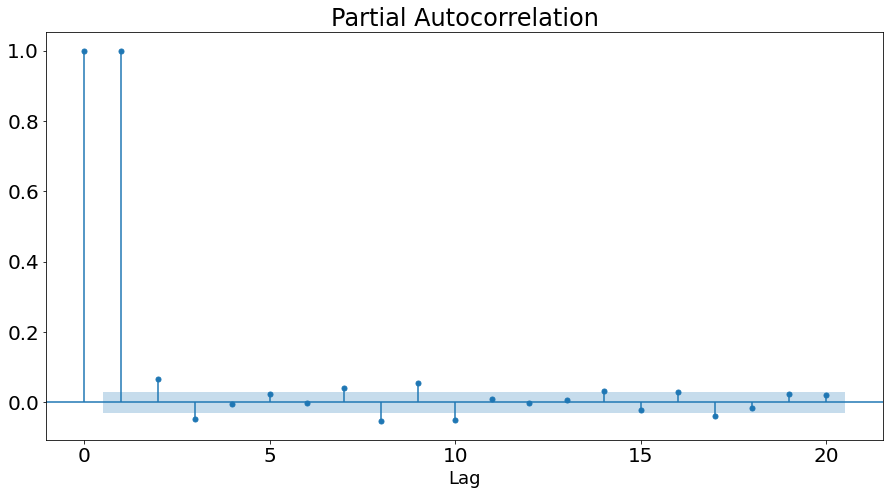

In [6]:
fig, ax = plt.subplots()
fig.set_size_inches(15,7.5)
plot_pacf(stocks['Adj Close'], ax = ax, lags=20)
ax.tick_params(labelsize = 20)
ax.set_xlabel("Lag",size = 18)
ax.set_title("Partial Autocorrelation" , fontsize = 24)
plt.savefig("figures/autocorrelation_SP500.png")
plt.show()

We can see that the PACF becomes almost silent after lag(1). This means that an AR model is best in our situation in comparison with MA model. See [PSU Stat510: PACF](https://online.stat.psu.edu/stat510/lesson/2/2.2)

In [7]:
stocks_plot = stocks.reset_index()

In [8]:
stocks_plot["First Diff"] = stocks_plot['Adj Close'] - stocks_plot['Adj Close'].shift()

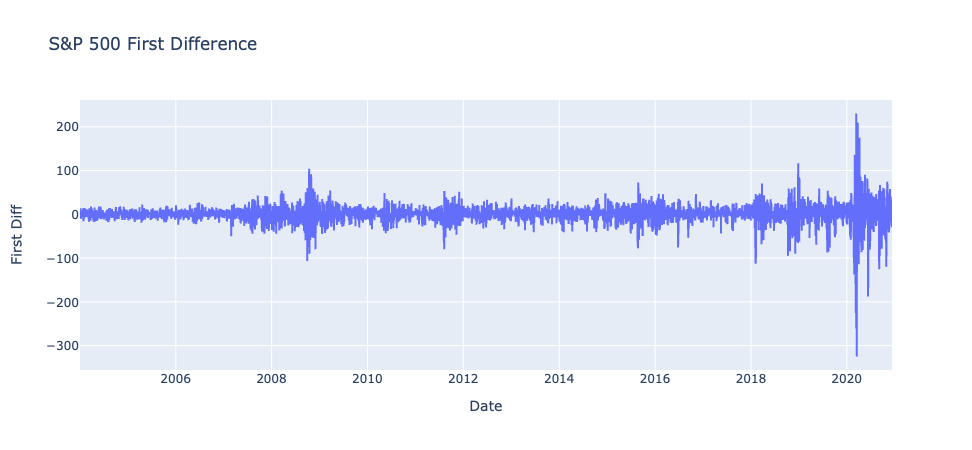

In [9]:
fig = px.line(stocks_plot, x='Date', y="First Diff", title='S&P 500 First Difference')
fig.update_layout({
'paper_bgcolor': 'rgba(0, 0, 0, 0)'
})
fig.show()
pio.write_html(fig, file='_includes/sp500_first_diff.html', auto_open=False)

In 2008, 2009 and in February/March 2020 which correspond to stock market crashes, we observe an exponential behaviour. To avoid that these periods overinfluence our models due to their high variance, we're going to apply the natural logarithm function to our values. 

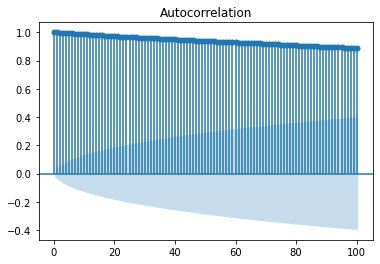

In [10]:
series = stocks['Adj Close']
plot_acf(series, lags=100)
plt.show()

The ACF is decreasing linearly with the number of lags. 

https://dspace.mit.edu/bitstream/handle/1721.1/55206/609415506-MIT.pdf?sequence=2&isAllowed=y

#### Seasonality

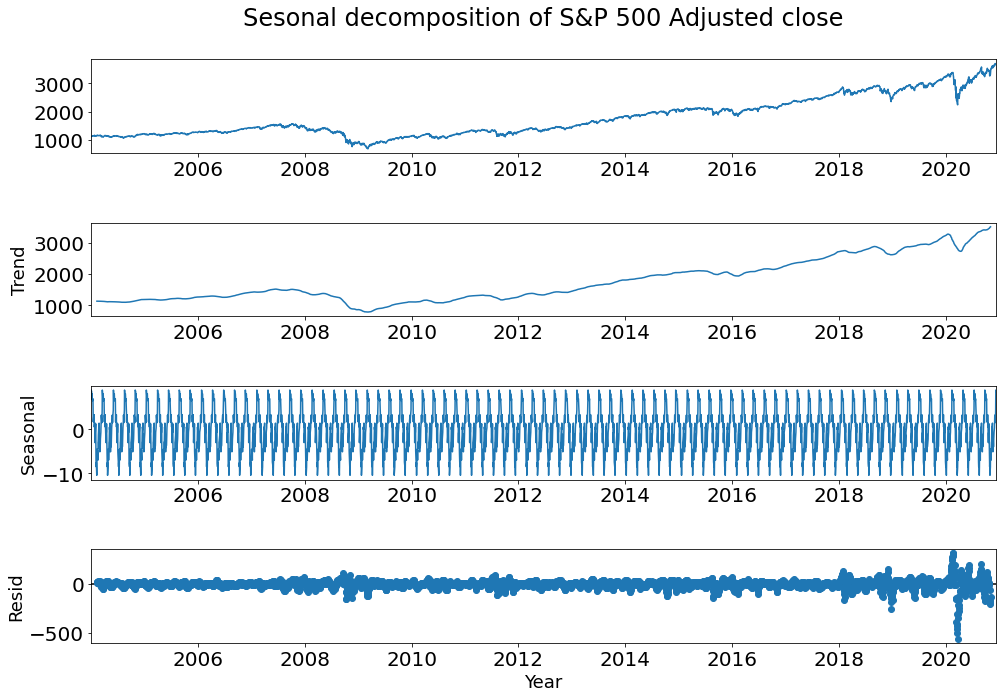

In [11]:
sd = seasonal_decompose(stocks['Adj Close'], model='additive', period=52)  
#plt.figure(figsize=(12, 10))
fig = sd.plot()
fig.set_size_inches(15,10)
allaxes = fig.get_axes()
for i,ax in enumerate(allaxes):
    ylab = ax.get_ylabel()
    ax.set_ylabel(ylab,fontsize = 18)
    ax.tick_params(labelsize = 20)
    if i == 0:
        ax.set_title('Sesonal decomposition of S&P 500 Adjusted close\n', fontsize = 24)
    if i == 3:
        ax.set_xlabel('Year',fontsize = 18)
plt.savefig('figures/Decompose_SP500.png')
plt.show()

There doesn't seem to be any significant yearly or weekly seasonality. Let's check the monthly seasonality. 

In [12]:
stocks['m'] = stocks.index.month

<AxesSubplot:xlabel='m'>

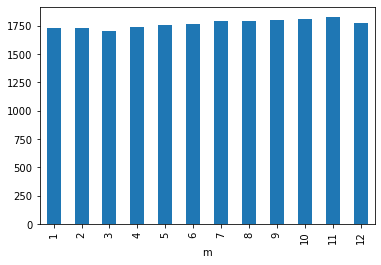

In [13]:
stocks.groupby('m')['Adj Close'].mean().plot.bar()

There is a weak monthly seasonality. 

We also show an example of trends data

In [14]:
trend_stocks = pd.read_csv('data/Keywords_US_Weekly/stocks.csv')
trend_stocks['date'] = pd.to_datetime(trend_stocks['date'])

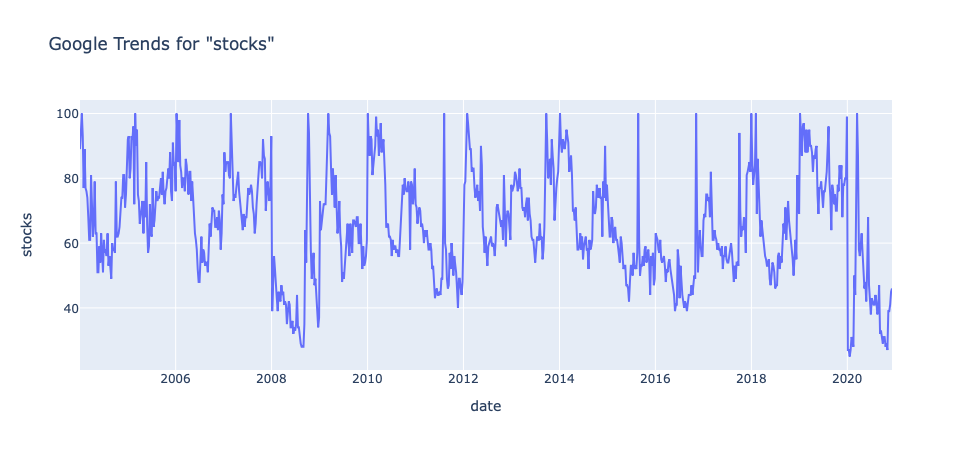

In [15]:
fig = px.line(trend_stocks, x='date', y="stocks", title='Google Trends for "stocks"')
fig.update_layout({
'paper_bgcolor': 'rgba(0, 0, 0, 0)'
})
fig.show()
pio.write_html(fig, file='_includes/trends_stocks.html', auto_open=False)

# 1.4 Preprocessing

#### Applying logn

In [16]:
stocks['Log Adj Close'] = list(map(lambda x: math.log1p(x), stocks['Adj Close'].values))
stocks_plot['Log Adj Close'] = list(map(lambda x: math.log1p(x), stocks_plot['Adj Close'].values))
stocks

Open         High          Low        Close    Adj Close  \
Date                                                                          
2004-01-02  1111.920044  1118.849976  1105.079956  1108.479980  1108.479980   
2004-01-05  1108.479980  1122.219971  1108.479980  1122.219971  1122.219971   
2004-01-06  1122.219971  1124.459961  1118.439941  1123.670044  1123.670044   
2004-01-07  1123.670044  1126.329956  1116.449951  1126.329956  1126.329956   
2004-01-08  1126.329956  1131.920044  1124.910034  1131.920044  1131.920044   
...                 ...          ...          ...          ...          ...   
2020-12-04  3670.939941  3699.199951  3670.939941  3699.120117  3699.120117   
2020-12-07  3694.729980  3697.409912  3678.879883  3691.959961  3691.959961   
2020-12-08  3683.050049  3708.449951  3678.830078  3702.250000  3702.250000   
2020-12-09  3705.979980  3712.389893  3660.540039  3672.820068  3672.820068   
2020-12-10  3659.129883  3678.489990  3645.179932  3668.100098  3668.100098   

                Volume   m  Log Adj Close  
Date                                       
2004-01-02  1153200000   1       7.011647  
2004-01-05  1578200000   1       7.023955  
2004-01-06  1494500000   1       7.025245  
2004-01-07  1704900000   1       7.027607  
2004-01-08  1868400000   1       7.032554  
...                ...  ..            ...  
2020-12-04  5086370000  12       8.216121  
2020-12-07  4788560000  12       8.214184  
2020-12-08  4549670000  12       8.216966  
2020-12-09  5209940000  12       8.208987  
2020-12-10  2380891125  12       8.207702  

[4266 rows x 8 columns]

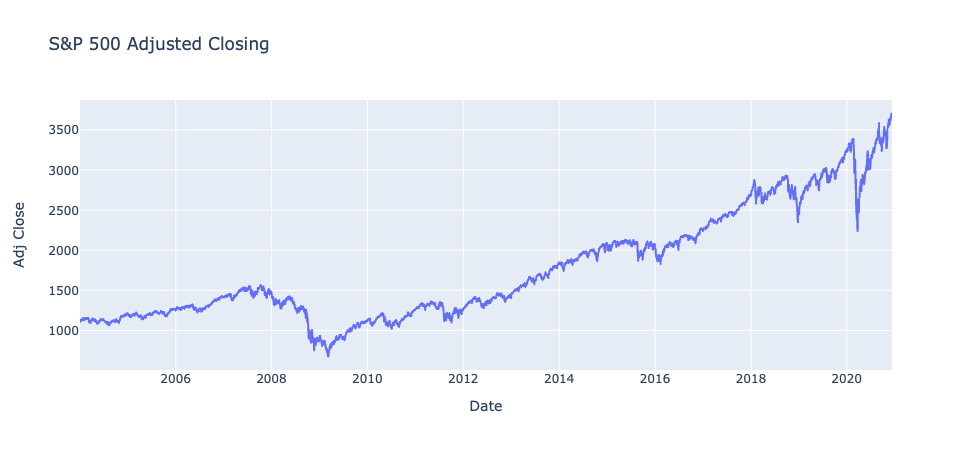

In [17]:
fig = px.line(stocks_plot, x='Date', y="Adj Close", title='S&P 500 Adjusted Closing')
fig.update_layout({
'paper_bgcolor': 'rgba(0, 0, 0, 0)'
})
fig.show()
pio.write_html(fig, file='_includes/sp500.html', auto_open=False)

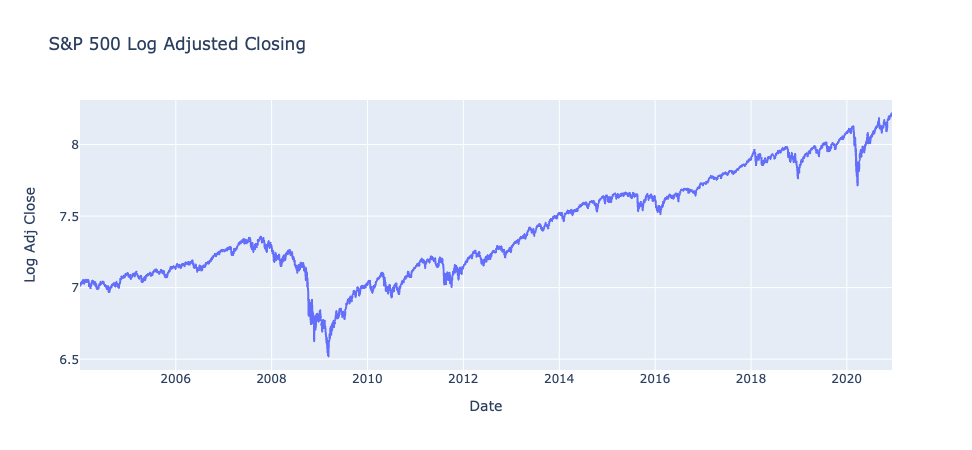

In [18]:
fig = px.line(stocks_plot, x='Date', y="Log Adj Close", title='S&P 500 Log Adjusted Closing')
fig.update_layout({
'paper_bgcolor': 'rgba(0, 0, 0, 0)'
})
fig.show()
pio.write_html(fig, file='_includes/sp500log.html', auto_open=False)

#### Resampling

The closing stock price is generally considered as an accurate market signal. (See [Closing Price](https://www.investopedia.com/terms/c/closingprice.asp)). Thereafter we'll only consider the Adjusted Closing value of each trading week.

In [19]:
keep_last = lambda x: x.tail(1)

In [20]:
stocks_wfri = stocks.resample('W-FRI').apply(keep_last)
stocks_wfri.head()

Open         High          Low        Close    Adj Close  \
Date                                                                          
2004-01-02  1111.920044  1118.849976  1105.079956  1108.479980  1108.479980   
2004-01-09  1131.920044  1131.920044  1120.900024  1121.859985  1121.859985   
2004-01-16  1132.050049  1139.829956  1132.050049  1139.829956  1139.829956   
2004-01-23  1143.939941  1150.310059  1136.849976  1141.550049  1141.550049   
2004-01-30  1134.109985  1134.170044  1127.729980  1131.130005  1131.130005   

                Volume  m  Log Adj Close  
Date                                      
2004-01-02  1153200000  1       7.011647  
2004-01-09  1720700000  1       7.023634  
2004-01-16  1721100000  1       7.039511  
2004-01-23  1561200000  1       7.041018  
2004-01-30  1635000000  1       7.031856

The closing stock price is considered as an accurate market signal. (See [Closing Price](https://www.investopedia.com/terms/c/closingprice.asp)). Thereafter we're considering only the Adjusted Closing value of each trading week.

### Putting data together

In [21]:
df.index = pd.to_datetime(df.index)
df = df.resample('W-FRI').apply(keep_last)
df.head()

mastercard  google  housing  pepsico  invest  hedge  bonds  \
date                                                                     
2004-01-09          63      56       75       27      77     69     81   
2004-01-16          68      55       90       33      63     69     81   
2004-01-23          61      62       81       22      59     70     77   
2004-01-30          50      57       78        0      65     65     72   
2004-02-06          77      57       78       64      62     67     75   

            revenues  finance  berkshire  ...  opportunity  happy  health  \
date                                      ...                               
2004-01-09        36       91         55  ...           42     62      99   
2004-01-16        29       93         28  ...           42     64      99   
2004-01-23        50       85         48  ...           34     69      98   
2004-01-30        88       97         31  ...          100     60      98   
2004-02-06        49       96         30  ...           46     57      93   

            mcdonalds  movie  return  comcast  medtronic  johnson  stocks  
date                                                                       
2004-01-09         55     82      94       75         66       25      89  
2004-01-16         56     79      91       74         44       26      97  
2004-01-23         46     78      83       80         61       26     100  
2004-01-30         62     77      87       72         40       25      93  
2004-02-06         62     70      90       58         77       27      77  

[5 rows x 86 columns]

In [22]:
stocks_wfri = stocks_wfri.iloc[1:,:]
stocks_wfri.head()

Open         High          Low        Close    Adj Close  \
Date                                                                          
2004-01-09  1131.920044  1131.920044  1120.900024  1121.859985  1121.859985   
2004-01-16  1132.050049  1139.829956  1132.050049  1139.829956  1139.829956   
2004-01-23  1143.939941  1150.310059  1136.849976  1141.550049  1141.550049   
2004-01-30  1134.109985  1134.170044  1127.729980  1131.130005  1131.130005   
2004-02-06  1128.589966  1142.790039  1128.390015  1142.760010  1142.760010   

                Volume  m  Log Adj Close  
Date                                      
2004-01-09  1720700000  1       7.023634  
2004-01-16  1721100000  1       7.039511  
2004-01-23  1561200000  1       7.041018  
2004-01-30  1635000000  1       7.031856  
2004-02-06  1477600000  2       7.042076

In [23]:
data = pd.concat([df, stocks_wfri], axis=1)
data.head()

mastercard  google  housing  pepsico  invest  hedge  bonds  \
date                                                                     
2004-01-09          63      56       75       27      77     69     81   
2004-01-16          68      55       90       33      63     69     81   
2004-01-23          61      62       81       22      59     70     77   
2004-01-30          50      57       78        0      65     65     72   
2004-02-06          77      57       78       64      62     67     75   

            revenues  finance  berkshire  ...  johnson  stocks         Open  \
date                                      ...                                 
2004-01-09        36       91         55  ...       25      89  1131.920044   
2004-01-16        29       93         28  ...       26      97  1132.050049   
2004-01-23        50       85         48  ...       26     100  1143.939941   
2004-01-30        88       97         31  ...       25      93  1134.109985   
2004-02-06        49       96         30  ...       27      77  1128.589966   

                   High          Low        Close    Adj Close      Volume  m  \
date                                                                            
2004-01-09  1131.920044  1120.900024  1121.859985  1121.859985  1720700000  1   
2004-01-16  1139.829956  1132.050049  1139.829956  1139.829956  1721100000  1   
2004-01-23  1150.310059  1136.849976  1141.550049  1141.550049  1561200000  1   
2004-01-30  1134.170044  1127.729980  1131.130005  1131.130005  1635000000  1   
2004-02-06  1142.790039  1128.390015  1142.760010  1142.760010  1477600000  2   

            Log Adj Close  
date                       
2004-01-09       7.023634  
2004-01-16       7.039511  
2004-01-23       7.041018  
2004-01-30       7.031856  
2004-02-06       7.042076  

[5 rows x 94 columns]

# 2. Prediction

First, we add lagged data to the model. That is the log of the stock value of the previous month and of the previous year. This translates into `t-4` and `t-52` as we are working with weekly data. The $\tau$ such that we add $t-\tau$ to the model is a parameter that could be optimized. However, we focused on optimizing the other parameters of the model as in the original paper they use `t-4` and `t-52` we decided to stick by it.

In [24]:
# look at value a month ago and a year ago (our time series is in weeks)

#df.iloc[0, df.columns.get_loc('COL_NAME')] = x


data['y(t-4)'] = np.nan
d_temp = list(data['Log Adj Close'].iloc[:-4])
data.iloc[4:,data.columns.get_loc('y(t-4)')] = d_temp
#pd.DataFrame(data['Log Adj Close']).T.shift(periods=4, axis=1).T

data['y(t-52)'] = np.nan
d_temp2 = list(data['Log Adj Close'].iloc[:-52])
data.iloc[52:, data.columns.get_loc('y(t-52)')] = d_temp2
#pd.DataFrame(data['Log Adj Close']).T.shift(periods=52, axis=1).T
#data = data.iloc[12:,:]

In [25]:
# delete rows with nan values due to this operation
data = data.iloc[52:,:]

In [26]:
# create separatwe dataframe containing X features
df_X = pd.concat([data.iloc[:,:-10], data.iloc[:,-2:]], axis=1)

In [27]:
df_X.columns

Index(['mastercard', 'google', 'housing', 'pepsico', 'invest', 'hedge',
       'bonds', 'revenues', 'finance', 'berkshire', 'consume', 'marriage',
       'home depot', 'environment', 'economy', 'short sell', 'leverage',
       'facebook', 'united health', 'amazon', 'merck', 'nyse', 'risk',
       'nasdaq', 'paypal', 'golf', 'pfizer', 'portfolio', 'food', 'cancer',
       'alphabet', 'procter and gamble', 'apple', 'netflix', 'abbott labs',
       'economics', 'success', 'credit', 'society', 'profit', 'intel', 'water',
       'fond', 'money', 'visa', 'rich', 'oracle', 'j p morgan', 'hold',
       'greed', 'spdr', 'investment', 'debt', 'present', 'loss', 'house',
       'gain', 'financial markets', 'employment', 'gross', 'consumption',
       'microsoft', 'crisis', 'inflation', 'adobe', 'headlines', 'at&t',
       'nvidia', 'transaction', 'buy', 'verizon communications', 'gains',
       'oil', 'war', 'cisco', 'unemployment', 'opportunity', 'happy', 'health',
       'mcdonalds', 'movie', '

In [28]:
X = df_X.values
y = data['Log Adj Close']

### Optimize Windows and number of features for model including trends

We perform grid search in order to find the optimal training window size and number of features to keep in the model. To find the best number of features, we iterate through all the possible number of features `k` and for each loop find the `k` features that yield the best correlation value according to the `f_regression` function.

In [29]:
from tqdm.notebook import tqdm
import time
start_time = time.time()

windows = np.arange(7, 30)

nb_features = np.arange(5, X.shape[1]+1)

grid = np.ndarray((len(windows), len(nb_features)))

for i, w in enumerate(windows):
    print('Optimizing for window of size ', w)
    for j, k in enumerate(nb_features):

        fs = SelectKBest(score_func=f_regression, k=k)
        fs.fit(X, y)
        X_new = fs.transform(X)
        
        y_test, y_hat = predict(X_new, y, w)
        
        mae = mean_absolute_error(y_test,y_hat)*100
        grid[i, j] = mae
print("--- %s seconds ---" % (time.time() - start_time))

Optimizing for window of size  7
Optimizing for window of size  8
Optimizing for window of size  9
Optimizing for window of size  10
Optimizing for window of size  11
Optimizing for window of size  12
Optimizing for window of size  13
Optimizing for window of size  14
Optimizing for window of size  15
Optimizing for window of size  16
Optimizing for window of size  17
Optimizing for window of size  18
Optimizing for window of size  19
Optimizing for window of size  20
Optimizing for window of size  21
Optimizing for window of size  22
Optimizing for window of size  23
Optimizing for window of size  24
Optimizing for window of size  25
Optimizing for window of size  26
Optimizing for window of size  27
Optimizing for window of size  28
Optimizing for window of size  29
--- 1139.6168279647827 seconds ---


In [30]:
window_idx, features_idx = np.where(grid == grid.min())

'The loss when using trends is minimized and returns {:.3f} for a window of size {} taking into account {} features'.format(np.min(grid), windows[window_idx[0]], nb_features[features_idx[0]])

'The loss when using trends is minimized and returns 2.288 for a window of size 8 taking into account 59 features'

Apply best results to the data

In [31]:
fs = SelectKBest(score_func=f_regression, k=nb_features[features_idx[0]])
fs.fit(X, y)
X_new = fs.transform(X)
        
y_test1, y_hat1 = predict(X_new, y, windows[window_idx[0]])
        
mae = mean_absolute_error(y_test1,y_hat1)*100

mae

2.288392651818309

In [32]:
mask = fs.get_support() #list of booleans
new_features = [] # The list of your K best features
feature_names = list(df_X.columns.values)


for bool, feature in zip(mask, feature_names):
    if bool:
        new_features.append(feature)
        print(feature)

mastercard
google
pepsico
invest
hedge
bonds
finance
berkshire
consume
marriage
home depot
short sell
leverage
facebook
amazon
merck
risk
nasdaq
paypal
golf
food
procter and gamble
netflix
credit
intel
water
fond
money
rich
oracle
j p morgan
hold
spdr
investment
loss
house
gain
employment
gross
microsoft
crisis
inflation
adobe
headlines
at&t
nvidia
buy
oil
war
cisco
unemployment
opportunity
health
mcdonalds
return
johnson
stocks
y(t-4)
y(t-52)


### Optimize Windows for model that doesn't include trends

We do the same with the data excluding all google trends to find optimum window

In [33]:
X_no_trends = df_X.iloc[:,-2:].values

start_time = time.time()

windows = np.arange(7, 30)

grid = []
for i, w in enumerate(windows):
    print('Computing loss for window of size ', w)
    y_test, y_hat = predict(X_no_trends, y, w)
        
    mae = mean_absolute_error(y_test,y_hat)*100
    grid.append(mae)
print("--- %s seconds ---" % (time.time() - start_time))

Computing loss for window of size  7
Computing loss for window of size  8
Computing loss for window of size  9
Computing loss for window of size  10
Computing loss for window of size  11
Computing loss for window of size  12
Computing loss for window of size  13
Computing loss for window of size  14
Computing loss for window of size  15
Computing loss for window of size  16
Computing loss for window of size  17
Computing loss for window of size  18
Computing loss for window of size  19
Computing loss for window of size  20
Computing loss for window of size  21
Computing loss for window of size  22
Computing loss for window of size  23
Computing loss for window of size  24
Computing loss for window of size  25
Computing loss for window of size  26
Computing loss for window of size  27
Computing loss for window of size  28
Computing loss for window of size  29
--- 13.125907897949219 seconds ---


In [34]:
'The loss without trends is minimized and returns {:.3f} for a window of size {}'.format(np.min(grid), windows[np.argmin(grid)])

'The loss without trends is minimized and returns 2.823 for a window of size 8'

In [35]:
y_test2, y_hat2 = predict(X_no_trends, y, 8)
        
mae_no_trends = mean_absolute_error(y_test2,y_hat2)*100

mae_no_trends

2.822926800911167

base 2.822926800911167
trends 2.288392651818309


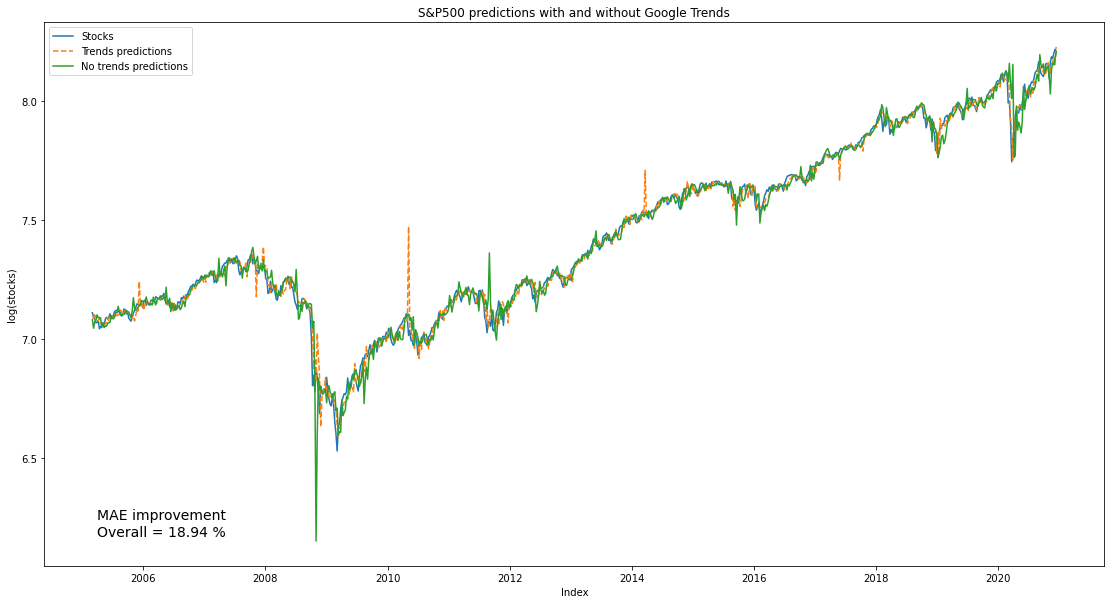

In [36]:
plot_fig(y_test1,y_test2, y_hat1,y_hat2)

In [37]:
plotly_fig(y_test1,y_test2, y_hat1,y_hat2)

# Turning points

In this part, we take a deeper look at turning points intervals in order to see if the google trends model performs better in such dates as well, and if so is it better than the overall improvement we've just seen before?

Below, we use the graph to detect the correct dates for the turning points. We find them by looking at the data and selecting them carefully.

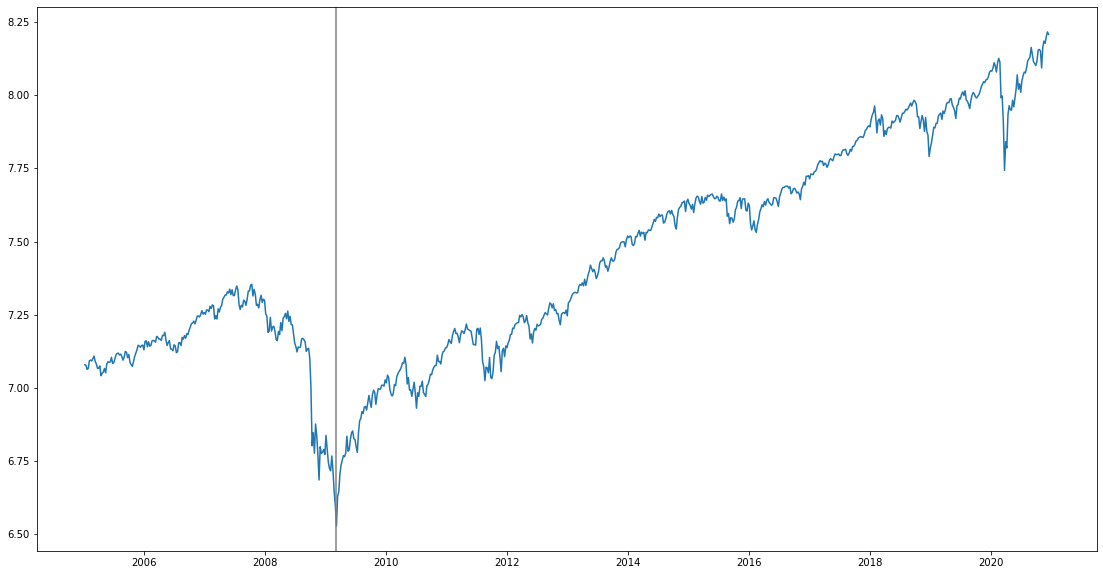

In [38]:
fig, ax = plt.subplots(figsize=(19,10))

ax.plot(data.index, data['Log Adj Close'], linestyle='solid', label='Actual')
ax.axvline(x=pd.to_datetime('2009-03-01'), ymin=0, ymax=6.75, color='grey')

In [48]:
tp1_start = '2008-08-15'
tp1_end = '2008-11-01'

tp2_start = '2009-02-01'
tp2_end = '2009-03-01'

tp3_start = '2011-07-15'
tp3_end = '2011-10-15'

tp4_start = '2015-08-01'
tp4_end = '2015-10-01'

tp5_start = '2016-01-01'
tp5_end = '2016-03-01'

tp6_start = '2018-11-20'
tp6_end = '2019-01-01'

tp7_start = '2020-02-15'
tp7_end = '2020-04-01'

In [49]:
tps = [
    [tp1_start, tp1_end],
    [tp2_start, tp2_end],
    [tp3_start, tp3_end],
    [tp4_start, tp4_end],
    [tp5_start, tp5_end],
    [tp6_start, tp6_end],
    [tp7_start, tp7_end],
]

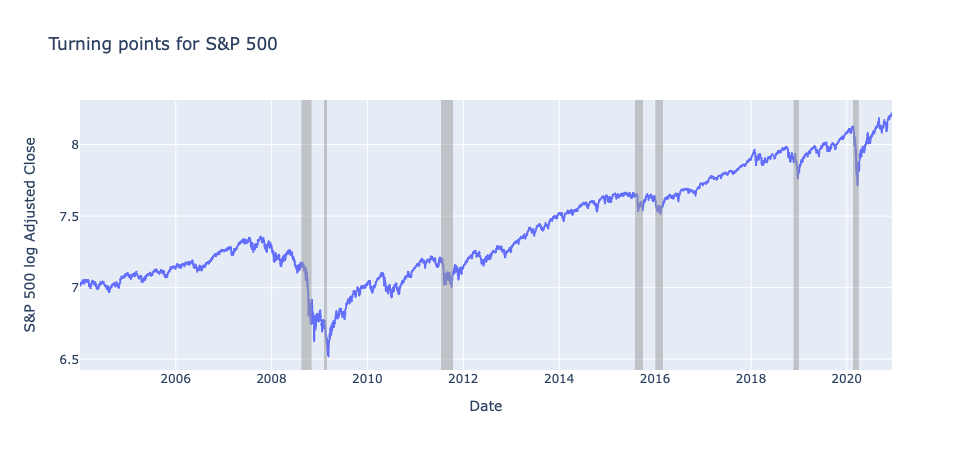

In [50]:
fig = px.line(stocks_plot, x='Date', y="Log Adj Close", title='S&P 500 Log Adjusted Closing')

fig.layout = {
    'shapes': [
        {
            'type': 'rect',
            # x-reference is assigned to the x-values
            'xref': 'x',
            # y-reference is assigned to the plot paper [0,1]
            'yref': 'paper',
            'x0': pd.to_datetime('2008-08-15'),
            'y0': 0,
            'x1': pd.to_datetime('2008-11-01'),
            'y1': 1,
            'fillcolor': '#999999',
            'opacity': 0.5,
            'line': {
                'width': 0,
            }
        },
        {
            'type': 'rect',
            # x-reference is assigned to the x-values
            'xref': 'x',
            # y-reference is assigned to the plot paper [0,1]
            'yref': 'paper',
            'x0': pd.to_datetime('2009-02-01'),
            'y0': 0,
            'x1': pd.to_datetime('2009-03-01'),
            'y1': 1,
            'fillcolor': '#999999',
            'opacity': 0.5,
            'line': {
                'width': 0,
            }
        },
        {
            'type': 'rect',
             # x-reference is assigned to the x-values
             'xref': 'x',
             # y-reference is assigned to the plot paper [0,1]
             'yref': 'paper',
            'x0': pd.to_datetime('2011-07-15'),
            'y0': 0,
            'x1': pd.to_datetime('2011-10-15'),
            'y1': 1,
            'fillcolor': '#999999',
            'opacity': 0.5,
            'line': {
                'width': 0,
            }
        },
        {
            'type': 'rect',
            # x-reference is assigned to the x-values
            'xref': 'x',
            # y-reference is assigned to the plot paper [0,1]
            'yref': 'paper',
            'x0': pd.to_datetime('2015-08-01'),
            'y0': 0,
            'x1': pd.to_datetime('2015-10-01'),
            'y1': 1,
            'fillcolor': '#999999',
            'opacity': 0.5,
            'line': {
                'width': 0,
            }
        },
        {
            'type': 'rect',
            # x-reference is assigned to the x-values
            'xref': 'x',
            # y-reference is assigned to the plot paper [0,1]
            'yref': 'paper',
            'x0': pd.to_datetime('2016-01-01'),
            'y0': 0,
            'x1': pd.to_datetime('2016-03-01'),
            'y1': 1,
            'fillcolor': '#999999',
            'opacity': 0.5,
            'line': {
                'width': 0,
            }
        },
        {
            'type': 'rect',
            # x-reference is assigned to the x-values
            'xref': 'x',
            # y-reference is assigned to the plot paper [0,1]
            'yref': 'paper',
            'x0': pd.to_datetime('2018-11-20'),
            'y0': 0,
            'x1': pd.to_datetime('2019-01-01'),
            'y1': 1,
            'fillcolor': '#999999',
            'opacity': 0.5,
            'line': {
                'width': 0,
            }
        },
        {
            'type': 'rect',
            # x-reference is assigned to the x-values
            'xref': 'x',
            # y-reference is assigned to the plot paper [0,1]
            'yref': 'paper',
            'x0': pd.to_datetime('2020-02-15'),
            'y0': 0,
            'x1': pd.to_datetime('2020-04-01'),
            'y1': 1,
            'fillcolor': '#999999',
            'opacity': 0.5,
            'line': {
                'width': 0,
            }
        }
    ],
}
    
fig.update_layout(title = 'Turning points for S&P 500',
                  xaxis_title="Date",
                  yaxis_title="S&P 500 log Adjusted Close",
                  paper_bgcolor = 'rgba(0, 0, 0, 0)')

fig.show()
pio.write_html(fig, file='_includes/turning_points.html', auto_open=False)

Below we compute the predictions

In [51]:
maes_tp_trends = []
maes_tp_notrends = []

#create our X matrices
X_temp_trends = df_X[new_features].values
X_temp_notrends = df_X.iloc[:,-2:].values

w_trends = 8
w_no_trends = 8

for tp in tps:
    
    #compute mae for each turning point with trends
    X_train = X_temp_trends[df_X.index < tp[0]]
    X_train = X_train[-w_trends:,:]
    X_test = X_temp_trends[(df_X.index>= tp[0]) & (df_X.index <= tp[1])]

    y_train = y[df_X.index < tp[0]]
    y_train = y_train[-w_trends:]
    y_test = y[(df_X.index>= tp[0]) & (df_X.index <= tp[1])]
    
    #print(X_train.shape)
    #print(len(y_train))
    
    reg = LinearRegression()
    reg.fit(X_train, y_train)
    y_preds = pred_tp(X_train, y_train, X_test, y_test)

    maes_tp_trends.append(mean_absolute_error(y_test, y_preds))

    # ----#

    #compute mae for each turning point without trends

    X_train = X_temp_notrends[df_X.index < tp[0]]
    X_train = X_train[-w_no_trends:,:]
    X_test = X_temp_notrends[(df_X.index>= tp[0]) & (df_X.index <= tp[1])]

    y_train = y[df_X.index < tp[0]]
    y_train = y_train[-w_no_trends:]
    y_test = y[(df_X.index>= tp[0]) & (df_X.index <= tp[1])]
    #print(X_train.shape)
    #print(len(y_train))
    y_preds = pred_tp_no_trends(X_train, y_train, X_test, y_test)

    maes_tp_notrends.append(mean_absolute_error(y_test, y_preds))

In [52]:
pcts = [str((maes_tp_notrends[i]-maes_tp_trends[i])/max(maes_tp_notrends[i], maes_tp_trends[i])*100)[:5]+'%' for i in range(len(maes_tp_trends))]

In [53]:
df = pd.DataFrame({
    'Start': [tp[0] for tp in tps],
    'End': [tp[1] for tp in tps],
    'MAE base': maes_tp_notrends,
    'MAE trends': maes_tp_trends,
    '1-ratio': pcts
})

In [54]:
df

Start         End  MAE base  MAE trends 1-ratio
0  2008-08-15  2008-11-01  0.122900    0.051921  57.75%
1  2009-02-01  2009-03-01  0.074223    0.057445  22.60%
2  2011-07-15  2011-10-15  0.075157    0.034318  54.33%
3  2015-08-01  2015-10-01  0.035358    0.024421  30.93%
4  2016-01-01  2016-03-01  0.029370    0.021017  28.44%
5  2018-11-20  2019-01-01  0.053062    0.038069  28.25%
6  2020-02-15  2020-04-01  0.165370    0.067717  59.05%

Finally, we can do our final plot while showing the google trends model's improvement during recession periods (turning points)

base 2.822926800911167
trends 2.288392651818309


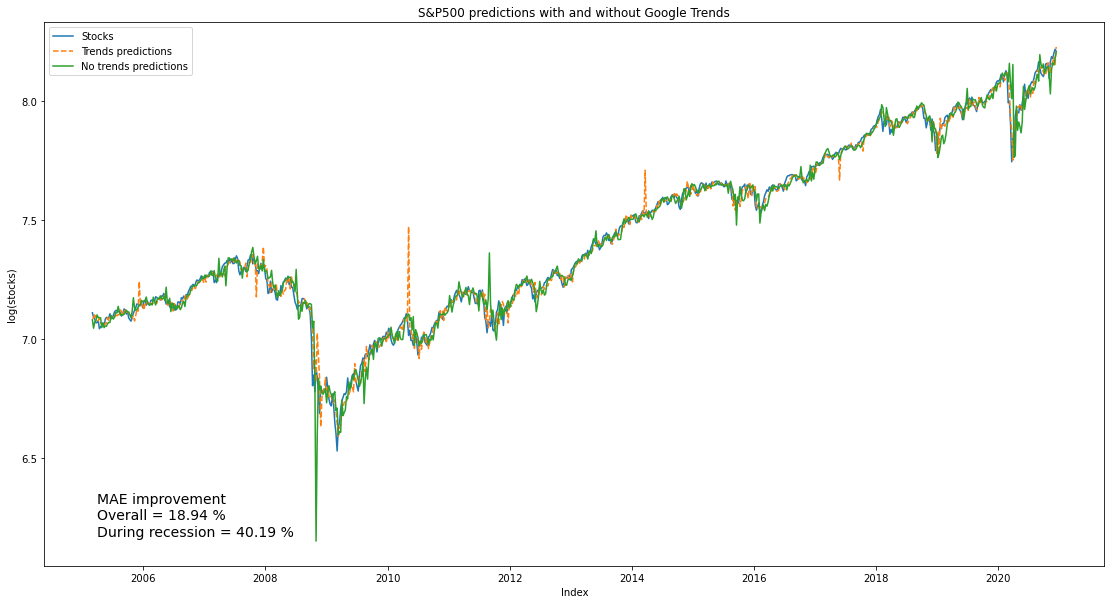

In [55]:
plot_fig(y_test1, y_test2, y_hat1, y_hat2, np.mean([float(el[:-1]) for el in pcts]), with_tp=True)

As we can see from the results of this research, is that the use of Google Trends actually improves the accuracy of the predictions. One thing we have done differently from the paper that yielded better results was to stick to a strict window of training points. In the paper, to predict a data point all previous data points are used. In our case, we decide to only use a certain window of data points as we assume that data from 10 years ago for instance will not help in our predictions. We took a particular interest in turning points moments, where we can see that the improvement of our model is almost doubled. We strongly suggest using Google trends to anyone interesting in predicting stock values. Another option could have been to use a more restrained stock market (S&P500 is quite broad) which may give even better results.

A last part of this project could be to make investment recommendations based on the prediction of a fall in stock price (we could set a certain threshold) and see how well our investment recommendation system would work, and how much money we could make from 2004 to 2020. Would we recommend our model to a friend looking forward investing his money?